In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [58]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Dataset train_sessions

- Primer producto visto
- Fecha de visualización del primer producto
- Último producto visto
- Fecha de visualización del último producto
- Tiempo total de sesión (s)
- Promedio de tiempo en artículos
- Momento del día de inicio de sesión
- Una cadena de productos vistos en orden

In [59]:
df_sessions = pd.read_csv('train_sessions.csv')

In [60]:
df_sessions.head()

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211


In [61]:
session_sorted = df_sessions.sort_values(by=['date'])

# First date of session
begin_df = session_sorted.groupby('session_id')['date'].first().rename('start_date')

# First product of session
first_prod=session_sorted.groupby('session_id')['item_id'].first().rename('first_prod')

# Number of products seen in the session
prod_count=session_sorted.groupby('session_id')['item_id'].count().rename('prod_count')

# Last date of the session
end_df = session_sorted.groupby('session_id')['date'].last().rename('end_date')

# Last product of the session
last_prod=session_sorted.groupby('session_id')['item_id'].first().rename('last_prod')

# Concat the datasets
times_df=pd.concat([begin_df,end_df,first_prod,last_prod,prod_count],axis=1)

# Proper time format
times_df['start_date']=pd.to_datetime(times_df['start_date'])
times_df['end_date']=pd.to_datetime(times_df['end_date'])

# Calculatind the date difference
times_df['time_diff']=(times_df.end_date-times_df.start_date).astype('timedelta64[s]')

# Calculating the time per product
times_df['time_per_prod']=times_df['time_diff']/times_df['prod_count']

# Adding the time of the day
mask=(times_df.start_date.dt.hour>=0) & (times_df.start_date.dt.hour<7)
times_df.loc[mask,'time_first_prod']='madrugada'
mask=(times_df.start_date.dt.hour>=7) & (times_df.start_date.dt.hour<12)
times_df.loc[mask,'time_first_prod']='día'
mask=(times_df.start_date.dt.hour>=12) & (times_df.start_date.dt.hour<18)
times_df.loc[mask,'time_first_prod']='tarde'
mask=(times_df.start_date.dt.hour>=18) & (times_df.start_date.dt.hour<24)
times_df.loc[mask,'time_first_prod']='noche'


In [62]:
# Get the product chain
df_sessions['idx'] = df_sessions.groupby('session_id').cumcount()
df_sessions['item_idx'] = 'product_' + df_sessions.idx.astype(str)

item = df_sessions.pivot(index='session_id',columns='item_idx',values='item_id')

item['item_serie']=item.astype(str).agg('-'.join,axis=1)

item['item_serie'].replace(r'.0','', regex=True, inplace=True)
item['item_serie'].replace(r'-nan','', regex=True, inplace=True)

item.head()

item_idx,product_0,product_1,product_10,product_11,product_12,product_13,product_14,product_15,product_16,product_17,...,product_91,product_92,product_93,product_94,product_95,product_96,product_97,product_98,product_99,item_serie
session_id,,,,,,,,,,,,,,,,,,,,,
3,9655.0,9655.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9655-9655
13,15654.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15654
18,18316.0,2507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18316-27-26
19,25772.0,6341.0,8813.0,19896.0,27937.0,23687.0,12804.0,1755.0,18936.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25772-6341-8813-19896-27937-23687-124-1755-189...
24,2927.0,11662.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2927-11662-2927-275-434-164-414-18539-18476


In [63]:
sessions=pd.concat([times_df,item['item_serie']], axis=1)
sessions

,start_date,end_date,first_prod,last_prod,prod_count,time_diff,time_per_prod,time_first_prod,item_serie
session_id,,,,,,,,,
3,2020-12-18 21:19:48.093,2020-12-18 21:25:00.373,9655,9655,2,312.0,156.000000,noche,9655-9655
13,2020-03-13 19:35:27.136,2020-03-13 19:35:27.136,15654,15654,1,0.0,0.000000,noche,15654
18,2020-08-26 19:15:47.232,2020-08-26 19:18:30.833,4026,4026,3,163.0,54.333333,noche,18316-27-26
19,2020-11-02 16:30:36.378,2020-11-02 16:48:39.343,19896,19896,17,1082.0,63.647059,tarde,25772-6341-8813-19896-27937-23687-124-1755-189...
24,2020-02-26 17:22:48.903,2020-02-26 18:24:32.770,2927,2927,9,3703.0,411.444444,tarde,2927-11662-2927-275-434-164-414-18539-18476
...,...,...,...,...,...,...,...,...,...
4439986,2021-05-13 11:46:56.606,2021-05-13 11:55:50.151,23502,23502,6,533.0,88.833333,día,13914-193-133-232-27733-12373
4439990,2020-08-22 11:38:48.785,2020-08-22 12:36:27.326,22093,22093,11,3458.0,314.363636,día,1389-293-293-7833-189-1131-28-17429-62-22551-211
4439994,2020-11-27 20:08:37.262,2020-11-27 20:08:37.262,25357,25357,1,0.0,0.000000,noche,25357


# Purchases

In [64]:
purchases = pd.read_csv('train_purchases.csv').set_index('session_id')
purchases['date']=pd.to_datetime(purchases['date'])
purchases.rename(columns={'item_id':'item_purch','date':'purch_date'}, inplace=True)
purchases.head()

,item_purch,purch_date
session_id,,
3,15085,2020-12-18 21:26:47.986
13,18626,2020-03-13 19:36:15.507
18,24911,2020-08-26 19:20:32.049
19,12534,2020-11-02 17:16:45.920
24,13226,2020-02-26 18:27:44.114


In [65]:
purchases.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 3 to 4440001
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   item_purch  1000000 non-null  int64         
 1   purch_date  1000000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 22.9 MB


# Features
- Tabla con sesiones y veces que se ha visto cada clúster

In [66]:
item_clust=pd.read_csv('cluster_assign.csv')

In [67]:
item_clust=item_clust[['item_id2', 'Cluster_pred']].set_index('item_id2')
item_clust

,Cluster_pred
item_id2,
2,3
3,4
4,4
7,2
8,4
...,...
28139,0
28140,1
28141,4


In [68]:
df_sess_clust=df_sessions.merge(item_clust, left_on='item_id', right_index=True)
df_sess_clust

,session_id,item_id,date,idx,item_idx,Cluster_pred
0,3,9655,2020-12-18 21:25:00.373,0,product_0,1
1,3,9655,2020-12-18 21:19:48.093,1,product_1,1
103605,97085,9655,2020-12-27 20:22:13.011,3,product_3,1
162423,152155,9655,2020-11-19 16:26:18.468,1,product_1,1
225780,210806,9655,2021-01-02 05:37:37.183,8,product_8,1
...,...,...,...,...,...,...
4737630,4434058,3416,2020-11-14 23:33:46.655,2,product_2,4
4737631,4434058,15964,2020-11-14 23:33:58.652,3,product_3,4
4739963,4436170,27863,2020-07-20 06:36:30.611,0,product_0,2
4741053,4437232,7735,2020-01-02 20:07:06.367,7,product_7,4


In [69]:
df_clust_count = df_sess_clust.groupby(['session_id', 'Cluster_pred'])['session_id'].aggregate('count').unstack().fillna(0)


In [70]:
df_clust_count

Cluster_pred,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
3,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
19,14.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
24,0.0,1.0,3.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4439986,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
4439990,7.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4439994,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Combinar los datasets

In [100]:
df=pd.concat([sessions, purchases, df_clust_count], axis=1)
df

,start_date,end_date,first_prod,last_prod,prod_count,time_diff,time_per_prod,time_first_prod,item_serie,item_purch,...,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,,,,,,,,,,,,
3,2020-12-18 21:19:48.093,2020-12-18 21:25:00.373,9655,9655,2,312.0,156.000000,noche,9655-9655,15085,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,2020-03-13 19:35:27.136,2020-03-13 19:35:27.136,15654,15654,1,0.0,0.000000,noche,15654,18626,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18,2020-08-26 19:15:47.232,2020-08-26 19:18:30.833,4026,4026,3,163.0,54.333333,noche,18316-27-26,24911,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
19,2020-11-02 16:30:36.378,2020-11-02 16:48:39.343,19896,19896,17,1082.0,63.647059,tarde,25772-6341-8813-19896-27937-23687-124-1755-189...,12534,...,14.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
24,2020-02-26 17:22:48.903,2020-02-26 18:24:32.770,2927,2927,9,3703.0,411.444444,tarde,2927-11662-2927-275-434-164-414-18539-18476,13226,...,0.0,1.0,3.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439986,2021-05-13 11:46:56.606,2021-05-13 11:55:50.151,23502,23502,6,533.0,88.833333,día,13914-193-133-232-27733-12373,2915,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
4439990,2020-08-22 11:38:48.785,2020-08-22 12:36:27.326,22093,22093,11,3458.0,314.363636,día,1389-293-293-7833-189-1131-28-17429-62-22551-211,8786,...,7.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4439994,2020-11-27 20:08:37.262,2020-11-27 20:08:37.262,25357,25357,1,0.0,0.000000,noche,25357,21630,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
df['item_purch'].nunique()

18907

In [132]:
df = df[df.index<2000]

df

,start_date,end_date,first_prod,last_prod,prod_count,time_diff,time_per_prod,time_first_prod,item_serie,item_purch,...,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,,,,,,,,,,,,
3,2020-12-18 21:19:48.093,2020-12-18 21:25:00.373,9655,9655,2,312.0,156.000000,noche,9655-9655,15085,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,2020-03-13 19:35:27.136,2020-03-13 19:35:27.136,15654,15654,1,0.0,0.000000,noche,15654,18626,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18,2020-08-26 19:15:47.232,2020-08-26 19:18:30.833,4026,4026,3,163.0,54.333333,noche,18316-27-26,24911,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
19,2020-11-02 16:30:36.378,2020-11-02 16:48:39.343,19896,19896,17,1082.0,63.647059,tarde,25772-6341-8813-19896-27937-23687-124-1755-189...,12534,...,14.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
24,2020-02-26 17:22:48.903,2020-02-26 18:24:32.770,2927,2927,9,3703.0,411.444444,tarde,2927-11662-2927-275-434-164-414-18539-18476,13226,...,0.0,1.0,3.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978,2021-01-17 11:29:51.272,2021-01-17 12:44:18.427,7157,7157,5,4467.0,893.400000,día,16882-7157-4-1818-7157,15926,...,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
1981,2020-12-26 20:21:34.791,2020-12-26 20:51:10.726,9859,9859,21,1775.0,84.523810,noche,25355-19157-26386-26725-17255-66-14669-287-146...,22836,...,2.0,0.0,0.0,7.0,11.0,0.0,1.0,0.0,0.0,0.0
1983,2020-08-07 22:05:07.755,2020-08-07 22:05:07.755,7722,7722,1,0.0,0.000000,noche,7722,3393,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
df.to_csv('dataset_merge.csv')

<AxesSubplot:>

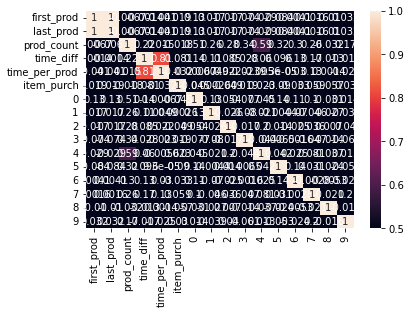

In [134]:
sns.heatmap(df.corr(), annot=True, vmin=0.5) # new 

### How many type of items are seen in each session?

In [135]:
df_clusts = df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
df_clusts = df_clusts.replace(0, np.nan)
df_clusts["distinct"] = df_clusts.count(1)
#df_clusts.head()
item_counts = df_clusts["distinct"].value_counts()
print(item_counts)

1    263
2     82
3     34
4     24
5     11
7      1
6      1
Name: distinct, dtype: int64


## Divide into train - validation

There are several ways to divide your training data. Sometimes it is important to create a stratified sampling.

In [136]:
df_clusts = df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
df_clusts = df_clusts.replace(0, np.nan)
df_clusts["sum"] = df_clusts.sum(axis=1)
df_clusts = df_clusts[df_clusts["sum"] > 4.0]
df_clusts["distinct"] = df_clusts[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]].count(1)
df_clusts.head()
item_counts = df_clusts["distinct"].value_counts()
print(item_counts)

2    37
1    32
3    27
4    23
5    11
7     1
6     1
Name: distinct, dtype: int64


In [137]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
len(train_set),len(test_set)

(332, 84)

## Prepare the data for Machine Learning algorithms

In [138]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(handle_unknown='ignore')
train_set_1hot = cat_encoder.fit_transform(train_set.fillna('Unknown'))

In [139]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [140]:
train_set_num = train_set[["prod_count", "time_diff", "time_per_prod", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [141]:
imputer.fit(train_set_num)
imputer.statistics_

array([  2.        , 122.        ,  28.66666667,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ])

In [142]:
train_set_num.median().values

array([  2.        , 122.        ,  28.66666667,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ])

In [143]:
X = imputer.transform(train_set_num)

In [144]:
train_set_tr = pd.DataFrame(X, columns=train_set_num.columns,
                          index=train_set.index)

In [145]:
imputer.strategy

'median'

In [146]:
train_set_tr.head()

,prod_count,time_diff,time_per_prod,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,,,,
1355,7.0,24115.0,3445.000000,0.0,0.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
1922,8.0,337.0,42.125000,0.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0
997,22.0,6903.0,313.772727,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0
494,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1760,9.0,705.0,78.333333,0.0,0.0,0.0,5.0,1.0,2.0,1.0,0.0,0.0,0.0


### Categorical data

Now let's preprocess the categorical input time_first_prod:

In [147]:
train_set_cat = train_set[["first_prod", "last_prod", "time_first_prod"]]
# There is missing values in this category, we will create a new cateogry for those.
train_set_cat.fillna('Unknown').head(10)

,first_prod,last_prod,time_first_prod
session_id,,,
1355,19587,19587,día
1922,16780,16780,madrugada
997,21594,21594,día
494,14680,14680,tarde
1760,9200,9200,tarde
813,15565,15565,noche
28,16895,16895,tarde
266,13615,13615,tarde
606,6221,6221,madrugada


In [148]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
train_set_cat_encoded = ordinal_encoder.fit_transform(train_set_cat.fillna('Unknown'))
train_set_cat_encoded[:10]

array([[220., 220.,   0.],
       [189., 189.,   1.],
       [248., 248.,   0.],
       [164., 164.,   3.],
       [121., 121.,   3.],
       [174., 174.,   2.],
       [191., 191.,   3.],
       [156., 156.,   3.],
       [ 75.,  75.,   1.],
       [206., 206.,   2.]])

In [149]:
ordinal_encoder.categories_

[array([  102,   107,   222,   252,   412,   484,   507,   729,   828,
         1018,  1172,  1206,  1350,  1442,  1515,  1637,  1660,  1750,
         1783,  1812,  1818,  1881,  1992,  2072,  2176,  2383,  2447,
         2472,  2587,  2683,  2796,  2845,  2855,  2915,  2927,  3117,
         3320,  3327,  3338,  3375,  3462,  3556,  3639,  3705,  3785,
         3880,  3919,  3978,  4026,  4028,  4131,  4219,  4528,  4707,
         4816,  4822,  4917,  5199,  5226,  5239,  5243,  5264,  5367,
         5370,  5409,  5458,  5704,  5730,  5818,  5990,  6107,  6110,
         6116,  6139,  6186,  6221,  6372,  6386,  6458,  6482,  6587,
         6588,  6589,  6714,  6736,  6938,  6942,  7046,  7064,  7196,
         7211,  7327,  7360,  7515,  7522,  7577,  7722,  7879,  7880,
         7884,  7892,  7963,  8060,  8180,  8267,  8362,  8398,  8425,
         8453,  8499,  8522,  8530,  8569,  8577,  8622,  8648,  8843,
         9005,  9052,  9169,  9185,  9200,  9442,  9522,  9582, 10052,
      

In [150]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(handle_unknown='ignore')
train_set_cat_1hot = cat_encoder.fit_transform(train_set_cat.fillna('Unknown'))
train_set_cat_1hot

<332x624 sparse matrix of type '<class 'numpy.float64'>'
	with 996 stored elements in Compressed Sparse Row format>

In [151]:
train_set_cat_1hot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [152]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

train_set_num_tr = num_pipeline.fit_transform(train_set_num)

In [153]:
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

In [154]:
from sklearn.compose import ColumnTransformer

num_attribs1 = train_set_num.select_dtypes(include="object").columns
cat_attribs = train_set_cat.select_dtypes(include="object").columns


full_pipeline = ColumnTransformer([
        ("num1", num_pipeline, num_attribs1),
        ("cat", cat_pipeline, cat_attribs),
    ])

train_set_prepared = full_pipeline.fit_transform(train_set)

train_set_prepared

<332x4 sparse matrix of type '<class 'numpy.float64'>'
	with 332 stored elements in Compressed Sparse Row format>

## Select and train a model

### Linear Regression

In [155]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_set_prepared, train_set[["item_purch"]])

LinearRegression()

In [156]:
from sklearn.metrics import mean_squared_error

train_set_predictions = lin_reg.predict(train_set_prepared)
lin_mse = mean_squared_error(train_set[["item_purch"]], train_set_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

8255.353503711498

RandomForestRegressor

In [157]:
## Let's try another model: Random Forest
from sklearn.ensemble import RandomForestClassifier

forest_class = RandomForestClassifier(n_estimators=20, random_state=42)
forest_class.fit(train_set_prepared, train_set[["item_purch"]].to_numpy().ravel())

RandomForestClassifier(n_estimators=20, random_state=42)

In [158]:
train_set_predictions = forest_class.predict(train_set_prepared)
forest_mse = mean_squared_error(train_set[["item_purch"]].to_numpy().ravel(), train_set_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse
forest_class.score(train_set_prepared, train_set[["item_purch"]].to_numpy().ravel())
#forest_reg.predict()

0.02710843373493976

In [159]:
test_set_num = test_set[["prod_count", "time_diff", "time_per_prod", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
test_set_cat = test_set[["first_prod", "last_prod", "time_first_prod"]]

num_attribs2 = test_set_num.select_dtypes(include="object").columns
cat_attribs2 = test_set_cat.select_dtypes(include="object").columns


full_pipeline = ColumnTransformer([
        ("num1", num_pipeline, num_attribs2),
        ("cat", cat_pipeline, cat_attribs2),
    ])

test_set_prepared = full_pipeline.fit_transform(test_set)

forest_class.score(test_set_prepared, test_set[["item_purch"]].to_numpy().ravel())

predictions = forest_class.predict(test_set_prepared[0])

In [160]:
predictions = forest_class.predict(test_set_prepared[0:100])
print(predictions)

[ 8060 21781  8060  7096  8060  8060  7096  7096  7096 21781  7096 21781
 21781  8060 21781  7096  8060  7096  8060  7096 21781  7096 21781 21781
 21781  8060  8060 21781  8060  7096  8060  7096  8060  7096 13250  8060
 13250  8060  8060  8060  8060 21781  7096  8060 13250  7096  7096  8060
 13250  7096  8060  7096  7096  8060  8060  7096 21781 21781  7096  8060
  7096  8060  7096 21781  7096  7096  7096 21781  7096  7096  8060  7096
  8060 21781  8060  8060 21781  8060  8060  8060  7096  8060  8060 13250]


## Generate TEST Submission

In [1]:
df_leader = pd.read_csv('test_leaderboard_sessions.csv')

NameError: name 'pd' is not defined

In [ ]:
leader_session_sorted = df_leader.sort_values(by=['date'])

# First date of session
leader_begin_df = leader_session_sorted.groupby('session_id')['date'].first().rename('start_date')

# First product of session
leader_first_prod=leader_session_sorted.groupby('session_id')['item_id'].first().rename('first_prod')

# Number of products seen in the session
leader_prod_count=leader_session_sorted.groupby('session_id')['item_id'].count().rename('prod_count')

# Last date of the session
leader_end_df = leader_session_sorted.groupby('session_id')['date'].last().rename('end_date')

# Last product of the session
leader_last_prod=leader_session_sorted.groupby('session_id')['item_id'].first().rename('last_prod')

# Concat the datasets
leader_times_df=pd.concat([leader_begin_df,leader_end_df,leader_first_prod,leader_last_prod,leader_prod_count],axis=1)

# Proper time format
leader_times_df['start_date']=pd.to_datetime(leader_times_df['start_date'])
leader_times_df['end_date']=pd.to_datetime(leader_times_df['end_date'])

# Calculatind the date difference
leader_times_df['time_diff']=(leader_times_df.end_date-leader_times_df.start_date).astype('timedelta64[s]')

# Calculating the time per product
leader_times_df['time_per_prod']=leader_times_df['time_diff']/leader_times_df['prod_count']

# Adding the time of the day
mask=(leader_times_df.start_date.dt.hour>=0) & (leader_times_df.start_date.dt.hour<7)
leader_times_df.loc[mask,'time_first_prod']='madrugada'
mask=(leader_times_df.start_date.dt.hour>=7) & (leader_times_df.start_date.dt.hour<12)
leader_times_df.loc[mask,'time_first_prod']='día'
mask=(leader_times_df.start_date.dt.hour>=12) & (leader_times_df.start_date.dt.hour<18)
leader_times_df.loc[mask,'time_first_prod']='tarde'
mask=(leader_times_df.start_date.dt.hour>=18) & (leader_times_df.start_date.dt.hour<24)
leader_times_df.loc[mask,'time_first_prod']='noche'

In [ ]:
leader_times_df

,start_date,end_date,first_prod,last_prod,prod_count,time_diff,time_per_prod,time_first_prod
session_id,,,,,,,,
26,2021-06-16 09:53:54.158,2021-06-16 09:53:54.158,19185,19185,1,0.0,0.000000,día
200,2021-06-25 12:23:40.811,2021-06-25 12:24:50.692,17089,17089,4,69.0,17.250000,tarde
205,2021-06-11 00:28:07.058,2021-06-11 00:28:07.058,8194,8194,1,0.0,0.000000,madrugada
495,2021-06-14 22:13:06.741,2021-06-14 22:13:06.741,6853,6853,1,0.0,0.000000,noche
521,2021-06-19 13:50:03.090,2021-06-19 13:50:03.090,26471,26471,1,0.0,0.000000,tarde
...,...,...,...,...,...,...,...,...
4439446,2021-06-11 17:16:12.243,2021-06-11 17:17:11.565,20770,20770,3,59.0,19.666667,tarde
4439458,2021-06-09 04:52:02.785,2021-06-09 04:54:45.378,11715,11715,2,162.0,81.000000,madrugada
4439550,2021-06-02 17:42:40.481,2021-06-02 17:42:40.481,19086,19086,1,0.0,0.000000,tarde


In [ ]:
df_sess_clust_leader=df_leader.merge(item_clust, left_on='item_id', right_index=True)
df_sess_clust_leader

,session_id,item_id,date,Cluster_pred
0,26,19185,2021-06-16 09:53:54.158,4
13240,239993,19185,2021-06-21 11:22:20.096,4
34682,661695,19185,2021-06-27 09:31:21.179,4
36264,699226,19185,2021-06-07 09:58:16.167,4
42810,830528,19185,2021-06-14 15:26:44.282,4
...,...,...,...,...
226231,4382253,7523,2021-06-18 14:05:33.111,6
227011,4397116,6327,2021-06-23 21:59:23.999,7
227515,4408745,10278,2021-06-06 11:23:56.511,1
228684,4428903,27394,2021-06-16 17:03:01.114,0


In [ ]:
df_sess_clust

,session_id,item_id,date,idx,item_idx,Cluster_pred
0,3,9655,2020-12-18 21:25:00.373,0,product_0,1
1,3,9655,2020-12-18 21:19:48.093,1,product_1,1
103605,97085,9655,2020-12-27 20:22:13.011,3,product_3,1
162423,152155,9655,2020-11-19 16:26:18.468,1,product_1,1
225780,210806,9655,2021-01-02 05:37:37.183,8,product_8,1
...,...,...,...,...,...,...
4737630,4434058,3416,2020-11-14 23:33:46.655,2,product_2,4
4737631,4434058,15964,2020-11-14 23:33:58.652,3,product_3,4
4739963,4436170,27863,2020-07-20 06:36:30.611,0,product_0,2
4741053,4437232,7735,2020-01-02 20:07:06.367,7,product_7,4


In [ ]:
df_clust_count_leader = df_sess_clust_leader.groupby(['session_id', 'Cluster_pred'])['session_id'].aggregate('count').unstack().fillna(0)

In [ ]:
df_leader=pd.concat([leader_times_df, df_clust_count_leader], axis=1)

In [ ]:
df_leader

,start_date,end_date,first_prod,last_prod,prod_count,time_diff,time_per_prod,time_first_prod,0,1,3,4,5,6,7,8,9
session_id,,,,,,,,,,,,,,,,,
26,2021-06-16 09:53:54.158,2021-06-16 09:53:54.158,19185,19185,1,0.0,0.000000,día,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
200,2021-06-25 12:23:40.811,2021-06-25 12:24:50.692,17089,17089,4,69.0,17.250000,tarde,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
205,2021-06-11 00:28:07.058,2021-06-11 00:28:07.058,8194,8194,1,0.0,0.000000,madrugada,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
495,2021-06-14 22:13:06.741,2021-06-14 22:13:06.741,6853,6853,1,0.0,0.000000,noche,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
521,2021-06-19 13:50:03.090,2021-06-19 13:50:03.090,26471,26471,1,0.0,0.000000,tarde,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439446,2021-06-11 17:16:12.243,2021-06-11 17:17:11.565,20770,20770,3,59.0,19.666667,tarde,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4439458,2021-06-09 04:52:02.785,2021-06-09 04:54:45.378,11715,11715,2,162.0,81.000000,madrugada,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4439550,2021-06-02 17:42:40.481,2021-06-02 17:42:40.481,19086,19086,1,0.0,0.000000,tarde,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
leader_set_num = df_leader[["prod_count", "time_diff", "time_per_prod", 0, 1, 3, 4, 5, 6, 7, 8, 9]]
leader_set_cat = df_leader[["first_prod", "last_prod", "time_first_prod"]]

num_attribs_leader = leader_set_num.select_dtypes(include="object").columns
cat_attribs_leader = leader_set_cat.select_dtypes(include="object").columns


full_pipeline = ColumnTransformer([
        ("num1", num_pipeline, num_attribs_leader),
        ("cat", cat_pipeline, cat_attribs_leader),
    ])

leader_set_prepared = full_pipeline.fit_transform(df_leader)

leader_set_prepared

<50000x4 sparse matrix of type '<class 'numpy.float64'>'
	with 50000 stored elements in Compressed Sparse Row format>

In [ ]:
predictions = forest_class.predict_proba(leader_set_prepared)
print(predictions)

[[0.         0.00812476 0.00825425 ... 0.         0.01243521 0.01145543]
 [0.00673504 0.         0.         ... 0.00777891 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00673504 0.         0.         ... 0.00777891 0.         0.        ]
 [0.         0.00812476 0.00825425 ... 0.         0.01243521 0.01145543]
 [0.         0.00812476 0.00825425 ... 0.         0.01243521 0.01145543]]


In [ ]:
forest_class.classes_

array([  132,   263,   412,   419,   445,   551,   570,   697,   717,
         761,   853,   860,   921,   974,  1018,  1024,  1108,  1221,
        1367,  1368,  1374,  1531,  1603,  1631,  1636,  1644,  1682,
        1729,  1812,  1864,  1947,  2011,  2405,  2496,  2504,  2632,
        2845,  2915,  3037,  3040,  3115,  3162,  3256,  3310,  3327,
        3393,  3423,  3469,  3587,  3702,  3732,  3774,  3913,  4062,
        4130,  4167,  4243,  4265,  4309,  4671,  4917,  5066,  5146,
        5154,  5164,  5355,  5390,  5578,  5642,  5858,  6140,  6289,
        6419,  6511,  6540,  6770,  6880,  7066,  7096,  7219,  7362,
        7551,  7665,  7792,  7828,  7849,  8033,  8046,  8060,  8193,
        8242,  8290,  8321,  8345,  8577,  8582,  8616,  8755,  8840,
        8861,  9106,  9184,  9262,  9284,  9354,  9442,  9528,  9534,
        9683,  9756,  9842,  9860,  9914,  9921,  9922,  9925, 10017,
       10061, 10126, 10209, 10346, 10390, 10581, 10611, 10707, 10909,
       10915, 10991,

In [ ]:
f = open('final_submission.csv', 'w')
f.write('session_id,item_id,rank' + '\n')
for i in range(len(predictions)):
    dicc={}
    for j in range(len(forest_class.classes_)):
        dicc[forest_class.classes_[j]] = predictions[i][j]
    dicc1 = {k: v for k, v in sorted(dicc.items(), key=lambda item: item[1], reverse=True)}
    for a in range(1,101):
        l = list(dicc1.items())[:101]
        f.write(str(df_leader.index[i]) + ',' + str(l[a][0]) + ',' + str(a) + '\n')